# Quantile Monotone Constraints GBM demo

## Prepare data

In [2]:
import numpy as np
np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

In [3]:
# prepare plot function
import matplotlib.pyplot as plt

# Plot the function, the prediction and the 95% confidence interval
def plot_prediction_quantile(xx, fxx, xx_label, X, y, y_pred,ylim, title, y_upper=None, y_lower=None, 
                             confidence_label=None):
    fig = plt.figure()
    plt.plot(xx, fxx, 'g:', label=xx_label)
    if (X is not None) and (y is not None):
        plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
    plt.plot(xx, y_pred, 'r-', label=u'Prediction')
    if (y_upper is not None) and (y_lower is not None):
        plt.plot(xx, y_upper, 'k-')
        plt.plot(xx, y_lower, 'k-')
        plt.fill(np.concatenate([xx, xx[::-1]]),
                 np.concatenate([y_upper, y_lower[::-1]]),
                 alpha=.5, fc='b', ec='None', label=confidence_label)
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(ylim)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

## H2O-3

In [4]:
# start h2o-3
import h2o
from h2o.estimators import H2OGradientBoostingEstimator as GBM
h2o.init(strict_version_check=False, port=54321)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_191"; Java(TM) SE Runtime Environment (build 1.8.0_191-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from /home/mori/Documents/h2o/code/h2o-3/build/h2o.jar
  Ice root: /tmp/tmpx2wstc3_
  JVM stdout: /tmp/tmpx2wstc3_/h2o_mori_started_from_python.out
  JVM stderr: /tmp/tmpx2wstc3_/h2o_mori_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.99999
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_mori_q10j29
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.127 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


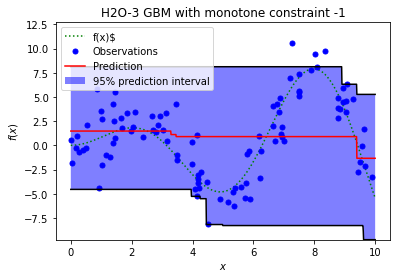

In [5]:
train_X = h2o.H2OFrame({'X': (X.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

train_xx = h2o.H2OFrame({'X': (xx.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

params = {"ntrees" : 100,
          "max_depth" : 5,
          "learn_rate" : 0.1,
          "min_rows" : 3,
          "nbins": 20,
          "nbins_top_level" : 20,
          "monotone_constraints" : {"X": -1}}

model_upper_h2o = GBM(distribution='quantile', quantile_alpha=0.95, **params)
model_upper_h2o.train(x='X', y='y', training_frame=train_X)
y_upper_h2o = list(model_upper_h2o.predict(train_xx).as_data_frame()['predict'])

model_lower_h2o = GBM(distribution='quantile', quantile_alpha=0.05, **params)
model_lower_h2o.train(x='X', y='y', training_frame=train_X)
y_lower_h2o = list(model_lower_h2o.predict(train_xx).as_data_frame()['predict'])

model_middle_h2o = GBM(distribution='quantile', quantile_alpha=0.5, **params)
model_middle_h2o.train(x='X', y='y', training_frame=train_X)
y_middle_h2o = list(model_middle_h2o.predict(train_xx).as_data_frame()['predict'])

model_h2o = GBM(distribution='gaussian', **params)

model_h2o.train(x='X', y='y', training_frame=train_X)
y_pred_h2o = list(model_h2o.predict(train_xx).as_data_frame()['predict'])

plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_h2o,[min(y)+0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM with monotone constraint -1",
                         y_upper_h2o, y_lower_h2o, '95% prediction interval')

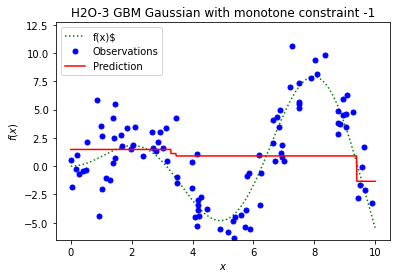

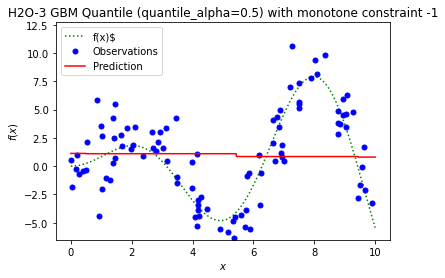

In [6]:
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_h2o, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM Gaussian with monotone constraint -1")
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_middle_h2o, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM Quantile (quantile_alpha=0.5) with monotone constraint -1")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


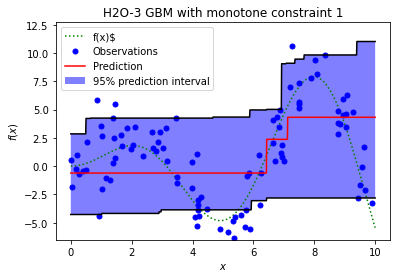

In [7]:
train_X = h2o.H2OFrame({'X': (X.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

train_xx = h2o.H2OFrame({'X': (xx.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

params = {"ntrees" : 100,
          "max_depth" : 5,
          "learn_rate" : 0.1,
          "min_rows" : 5,
          "nbins": 20,
          "nbins_top_level" : 20,
          "monotone_constraints" : {"X": 1}}

model_upper_h2o = GBM(distribution='quantile', quantile_alpha=0.95, **params)
model_upper_h2o.train(x='X', y='y', training_frame=train_X)
y_upper_h2o = list(model_upper_h2o.predict(train_xx).as_data_frame()['predict'])

model_lower_h2o = GBM(distribution='quantile', quantile_alpha=0.05, **params)
model_lower_h2o.train(x='X', y='y', training_frame=train_X)
y_lower_h2o = list(model_lower_h2o.predict(train_xx).as_data_frame()['predict'])

model_middle_h2o = GBM(distribution='quantile', quantile_alpha=0.5, **params)
model_middle_h2o.train(x='X', y='y', training_frame=train_X)
y_middle_h2o = list(model_middle_h2o.predict(train_xx).as_data_frame()['predict'])

model_h2o = GBM(distribution='gaussian', **params)

model_h2o.train(x='X', y='y', training_frame=train_X)
y_pred_h2o = list(model_h2o.predict(train_xx).as_data_frame()['predict'])

plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_h2o,[min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM with monotone constraint 1",
                         y_upper_h2o, y_lower_h2o, '95% prediction interval')

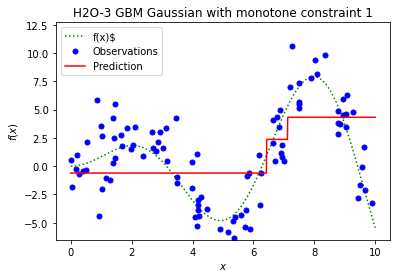

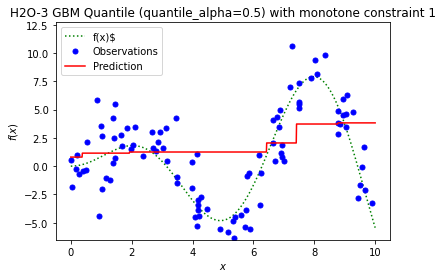

In [8]:
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_h2o, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM Gaussian with monotone constraint 1")
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_middle_h2o, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM Quantile (quantile_alpha=0.5) with monotone constraint 1")

In [9]:
# Print H2O GBM tree using Graphviz
# dot path is the path to a folder to save temporary dot file of mojo model
def plot_trees(model, tree_index=None, dot_path='tree.dot'):
    try:
        import graphviz
        mojo_path = model.download_mojo()
        mojo_dot = h2o.print_mojo(mojo_path, format='dot')

        with open(dot_path, 'a') as the_file:
            the_file.write(mojo_dot)
        
        return graphviz.Source(mojo_dot)
    except Exception as e:
        print("Error occured: "+str(e))

In [10]:
plot_trees(model_upper_h2o)

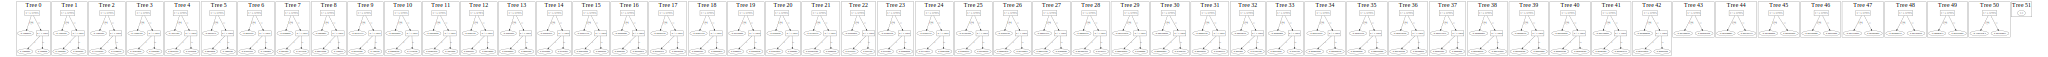

In [11]:
plot_trees(model_h2o)

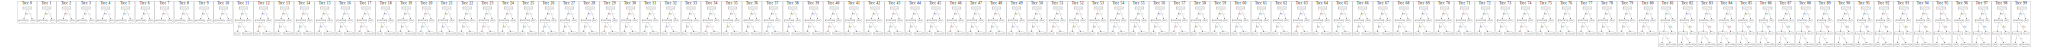

In [12]:
plot_trees(model_lower_h2o)

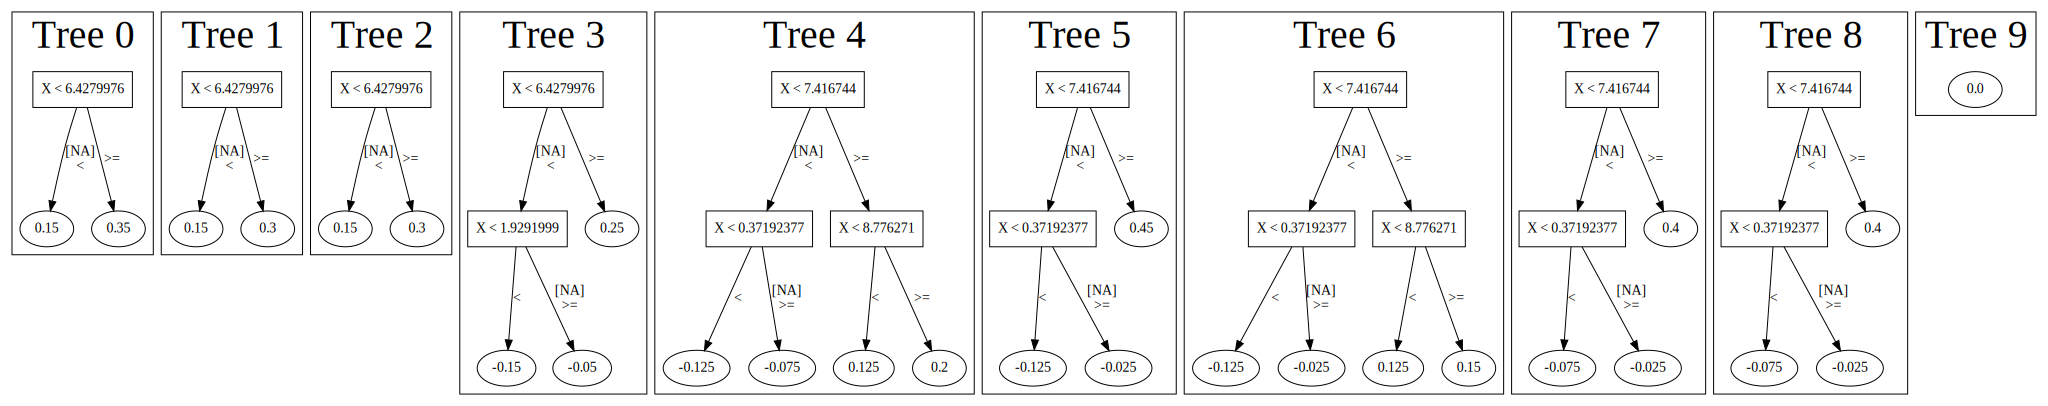

In [13]:
plot_trees(model_middle_h2o)

# Test performance

In [14]:
def f(x):
    """The function to predict."""
    return x * x

def generate_data(data_size):
    X = np.atleast_2d(np.random.uniform(0, 10.0, size=data_size)).T
    X = X.astype(np.float32)

    # Observations
    y = f(X).ravel()

    dy = 1.5 + 1.0 * np.random.random(y.shape)
    noise = np.random.normal(0, dy)
    y += noise
    y = y.astype(np.float32)

    xx = np.atleast_2d(np.linspace(0, 10, data_size)).T
    xx = xx.astype(np.float32)
    return X, y, xx

In [15]:
X, y, xx = generate_data(10000)
train_X = h2o.H2OFrame({'X': (X.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

train_xx = h2o.H2OFrame({'X': (xx.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

params = {"ntrees" : 50,
          "max_depth" : 10,
          "learn_rate" : 0.01,
          "min_rows" : 100,
          "nbins": 50,
          "nbins_top_level" : 50,
          "monotone_constraints" : {"X": 1},
          "stopping_rounds": 3}

import time

monotone_start = time.time()
model_monotone = GBM(distribution='quantile', quantile_alpha=0.5, **params)
model_monotone.train(x='X', y='y', training_frame=train_X)
model_monotone_preds = list(model_monotone.predict(train_xx).as_data_frame()['predict'])
print("Monotone quantile time: "+str(time.time()- monotone_start))

start = time.time()
model = GBM(distribution='gaussian', **params)
model.train(x='X', y='y', training_frame=train_X)
model_preds = list(model.predict(train_xx).as_data_frame()['predict'])
print("Quantile time: "+str(time.time()-start))


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/home/mori/Documents/h2o/code/h2o-3/h2o-py/h2o/estimators/estimator_base.py:208: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Monotone quantile time: 1.1657137870788574
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Quantile time: 0.696892499923706


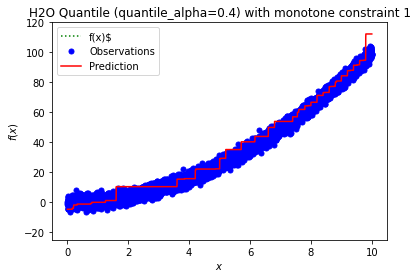

In [16]:
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, model_monotone_preds, [-25, 120], "H2O Quantile (quantile_alpha=0.4) with monotone constraint 1")

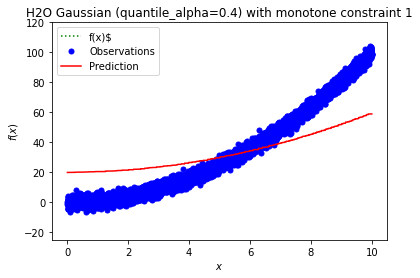

In [17]:
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, model_preds, [-25, 120], "H2O Gaussian (quantile_alpha=0.4) with monotone constraint 1")

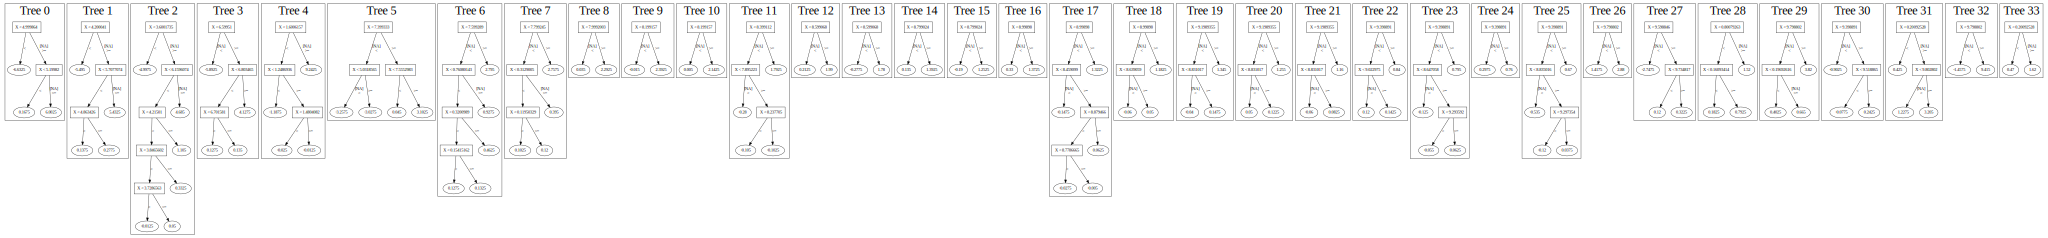

In [18]:
plot_trees(model_monotone)

In [ ]:
plot_trees(model)